## Basic Image Info (Metrics)

| Metric                              | Description                                                                                                               | Example                                                      | Interpretation                                                                                      |
|-------------------------------------|---------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------|----------------------------------------------------------------------------------------------------|
| **1. File Size**                    | The size of the image file in bytes.                                                                                      | `File Size: 204800 bytes`                                    | Indicates the storage space the image file occupies. Larger file sizes may imply higher resolution or less compression. |
| **2. Aspect Ratio**                 | The ratio of the width to the height of the image, stored as a vector.                                                    | `Aspect Ratio: (1920, 1080)`                                 | Helps in understanding the shape of the image (e.g., wide, tall, square). Represented as a tuple of width and height.   |
| **3. Width**                        | The width of the image in pixels.                                                                                         | `Width: 1920 pixels`                                         |                                                                                                    |
| **4. Height**                       | The height of the image in pixels.                                                                                        | `Height: 1080 pixels`                                        |                                                                                                    |
| **5. Resolution**                   | The resolution of the image, often measured in DPI (Dots Per Inch).                                                       | `Resolution (DPI): (300, 300)`                               | Higher DPI values indicate better image quality, which is crucial for printing purposes.            |
| **6. Color Mode**                   | The color mode of the image (e.g., RGB, CMYK).                                                                            | `Color Mode: RGB`                                            | Different color modes are used for different purposes. RGB is common for digital images, while CMYK is used for printing. |
| **7. Bit Depth**                    | The bit depth of the image, indicating the number of bits used to represent each color channel.                           | `Bit Depth: 8-bit`                                           | Higher bit depths allow for more colors and greater detail. An 8-bit image can display 256 colors per channel.           |
| **8. Number of Unique Colors**      | The total number of unique colors in the image.                                                                           | `Unique Colors: 1024`                                        | A higher number of unique colors can indicate a more complex and detailed image.                    |
| **9. Dominant Colors**              | The most prevalent colors in the image, often determined through clustering algorithms like KMeans.                       | `Dominant Colors: [(255, 0, 0), (0, 255, 0), (0, 0, 255)]`   | Useful for understanding the image's overall color palette.                                         |
| **10. Metadata**                    | Additional information embedded in the image, such as camera model, exposure settings, and date taken.                    | `Metadata: {'Camera': 'Nikon D3500', 'Exposure': '1/60', 'Date Taken': '2021-05-15'}` | Provides context about how and when the image was captured.                                         |
| **11. Compression Type**            | The type of compression used to store the image (e.g., JPEG, PNG).                                                        | `Compression Type: JPEG`                                     | Different compression types have different impacts on image quality and file size. JPEG is lossy, while PNG is lossless. |
| **12. Image Format**                | The file format of the image (e.g., JPEG, PNG).                                                                           | `Image Format: JPEG`                                         |                                                                                                    |
| **13. Mean and Standard Deviation of Color Channels** | Statistical measures of the color channels in the image.                                                                 | `Mean Color Channels: [123.4, 135.6, 145.7]`                 | The mean gives the average color value, while the standard deviation indicates the variation in color. |
| **14. Histogram of Color Channels** | A histogram representing the distribution of color values in the image.                                                   | `Histogram: [0, 5, 13, ..., 2]`                              | Helps visualize the spread and intensity of colors in the image.                                    |
| **15. Presence of Alpha Channel**   | Indicates whether the image has an alpha (transparency) channel.                                                          | `Alpha Channel: True`                                        | An alpha channel allows for transparency in the image.                                              |
| **16. Entropy**                     | A measure of randomness or complexity in the image.                                                                       | `Entropy: 7.85`                                              | Higher entropy values suggest more complexity and detail in the image.                              |
| **17. Brightness**                  | The average brightness of the image.                                                                                      | `Brightness: 120.5`                                          | Higher values indicate a brighter image.                                                           |
| **18. Contrast**                    | The difference between the darkest and lightest parts of the image.                                                       | `Contrast: 45.3`                                             | Higher contrast values indicate a greater difference between light and dark areas, making the image appear more vivid.  |
| **19. Sharpness**                   | A measure of the clarity of edges in the image.                                                                           | `Sharpness: 1500.0`                                          | Higher sharpness values indicate clearer, more defined edges in the image.                          |
| **20. Texture**                     | The perceived surface quality or feel of the image (e.g., smoothness, roughness).                                         | `Texture: High smoothness`                                   | Texture analysis can be used in various applications such as material identification and image segmentation.            |
| **21. Geometric Features**          | Features related to the shapes and structures within the image (e.g., number of edges, contours).                         | `Geometric Features: 500 edges detected`                     | Helps in understanding the structural elements of the image, useful in object recognition.           |
| **22. Saturation**                  | The intensity of colors in the image.                                                                                     | `Saturation: 70.0`                                           | Higher saturation values indicate more intense and vivid colors.                                     |

By analyzing these metrics, we can gain a comprehensive understanding of the image's properties and characteristics, enabling better organization, search, and utilization in various applications.


In [14]:
# Image
image_path = './images/exampleImage_02.png'

In [15]:
from PIL import Image, ImageStat
import os
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
import cv2
from math import gcd

def get_image_info(image_path):
    # Open the image
    image = Image.open(image_path)
    
    # Basic Info
    file_size = os.path.getsize(image_path)
    width, height = image.size
    
    # Reduce aspect ratio to simplest form
    def reduce_aspect_ratio(width, height):
        divisor = gcd(width, height)
        return (width // divisor, height // divisor)
    
    aspect_ratio = reduce_aspect_ratio(width, height)
    
    color_mode = image.mode
    format = image.format
    bit_depth = image.mode  # Bit depth inferred from mode
    
    # Resolution
    dpi = image.info.get('dpi', (None, None))
    
    # Unique Colors
    unique_colors = len(image.getcolors(image.size[0] * image.size[1]))
    
    # Image Histogram
    histogram = image.histogram()
    
    # Dominant Colors
    def get_dominant_colors(image, k=5):
        image = image.convert('RGB')
        image_np = np.array(image)
        pixels = image_np.reshape(-1, 3)
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(pixels)
        colors = kmeans.cluster_centers_
        counts = Counter(kmeans.labels_)
        dominant_colors = colors[np.argsort(-np.array(list(counts.values())))]
        return dominant_colors
    
    dominant_colors = get_dominant_colors(image)
    
    # Mean and Standard Deviation of Color Channels
    stat = ImageStat.Stat(image)
    mean = stat.mean
    stddev = stat.stddev
    
    # Entropy
    entropy = image.entropy()
    
    # Brightness
    grayscale = image.convert('L')
    brightness = ImageStat.Stat(grayscale).mean[0]
    
    # Contrast
    contrast = ImageStat.Stat(grayscale).stddev[0]
    
    # Presence of Alpha Channel
    alpha_channel = 'A' in image.mode
    
    # Additional features using OpenCV
    image_cv = cv2.imread(image_path)
    sharpness = cv2.Laplacian(image_cv, cv2.CV_64F).var()
    
    info = {
        'File Size': file_size,
        'Width': width,
        'Height': height,
        'Aspect Ratio': aspect_ratio,
        'Color Mode': color_mode,
        'Format': format,
        'Bit Depth': bit_depth,
        'Resolution (DPI)': dpi,
        'Unique Colors': unique_colors,
        'Dominant Colors': dominant_colors.tolist(),
        'Mean Color Channels': mean,
        'Stddev Color Channels': stddev,
        'Entropy': entropy,
        'Brightness': brightness,
        'Contrast': contrast,
        'Alpha Channel': alpha_channel,
        'Sharpness': sharpness,
        'Path': image_path
    }
    
    return info

# Example usage
image_info = get_image_info(image_path)
for key, value in image_info.items():
    print(f'{key}: {value}')


File Size: 1383860
Width: 1024
Height: 1024
Aspect Ratio: (1, 1)
Color Mode: RGB
Format: PNG
Bit Depth: RGB
Resolution (DPI): (None, None)
Unique Colors: 380466
Dominant Colors: [[141.658710641786, 201.99655721105165, 206.28009065046533], [5.235983065338537, 6.034759319729297, 6.091039256687857], [150.50286793059126, 101.04301092544986, 74.89553341902314], [37.531746754914224, 53.553093496574746, 54.11837625599523], [24.491866529861912, 150.7151575392245, 161.0750716087384]]
Mean Color Channels: [45.12664222717285, 60.54362106323242, 58.943793296813965]
Stddev Color Channels: [60.33951682694264, 68.02120429845027, 69.53420009120804]
Entropy: 7.7137299965627335
Brightness: 55.74748992919922
Contrast: 61.289603383415056
Alpha Channel: False
Sharpness: 1165.359216528103
Path: ./images/exampleImage_02.png


## Visualize Aspect Ratio

### Description

The `showAR` function visualizes different aspect ratios by displaying a reference red square (1:1 aspect ratio) and a blue rectangle representing the provided aspect ratio. Both shapes are centered on the plot to ensure clear and accurate comparison.

### How It Works

1. **Aspect Ratio Reduction**: The aspect ratio is reduced to its simplest form using the greatest common divisor (GCD).
2. **Plot Creation**: A plot is created with Matplotlib, and both the reference square and the aspect ratio rectangle are defined and centered on the plot.
3. **Normalization**: The aspect ratio is normalized to fit within the plot size while maintaining its proportions.
4. **Legend**: A legend is added to label the reference square and the aspect ratio rectangle.

### Output

The function displays a plot with:
- A centered red square representing a 1:1 aspect ratio.
- A centered blue rectangle representing the specified aspect ratio, reduced to its simplest form.
- A legend indicating which shape corresponds to which aspect ratio.

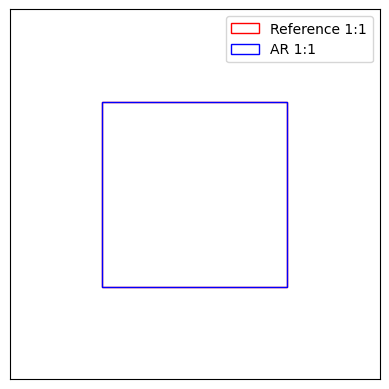

In [16]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from math import gcd

def reduce_aspect_ratio(width, height):
    divisor = gcd(width, height)
    return (width // divisor, height // divisor)

def showAR(aspect_ratio):
    # Reduce the aspect ratio to its simplest form
    width, height = reduce_aspect_ratio(*aspect_ratio)

    # Create a figure and a set of subplots
    fig, ax = plt.subplots()

    # Define the size of the red square
    square_size = 1
    square_x = (2 - square_size) / 2
    square_y = (2 - square_size) / 2
    square = plt.Rectangle((square_x, square_y), square_size, square_size, fill=None, edgecolor='r', label='Reference 1:1')

    # Add the red square to the plot
    ax.add_patch(square)

    # Normalize the aspect ratio to fit within the plot size
    aspect_ratio_max = max(width, height)
    normalized_width = width / aspect_ratio_max
    normalized_height = height / aspect_ratio_max

    # Calculate position to keep it centered
    rect_x = (2 - normalized_width) / 2
    rect_y = (2 - normalized_height) / 2
    aspect_rect = plt.Rectangle((rect_x, rect_y), normalized_width, normalized_height, fill=None, edgecolor='b', label=f'AR {width}:{height}')

    # Add the aspect ratio rectangle to the plot
    ax.add_patch(aspect_rect)

    # Set the limits of the plot
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 2)

    # Set aspect of the plot to be equal
    ax.set_aspect('equal')

    # Remove the numbers on the chart
    ax.set_xticks([])
    ax.set_yticks([])

    # Add a legend to the plot
    ax.legend()

    # Display the plot
    plt.show()

# * Example usage of the function with aspect ratio
    # From example image data
imageInfo_ar = image_info["Aspect Ratio"]
# * Alternate ARs to test
# imageInfo_ar = (5,7)
# imageInfo_ar = (16,9)

showAR(imageInfo_ar)


## Colormode

Dropdown(description='Color Mode:', index=3, options=('1', 'L', 'P', 'RGB', 'RGBA', 'CMYK', 'YCbCr', 'LAB', 'H…

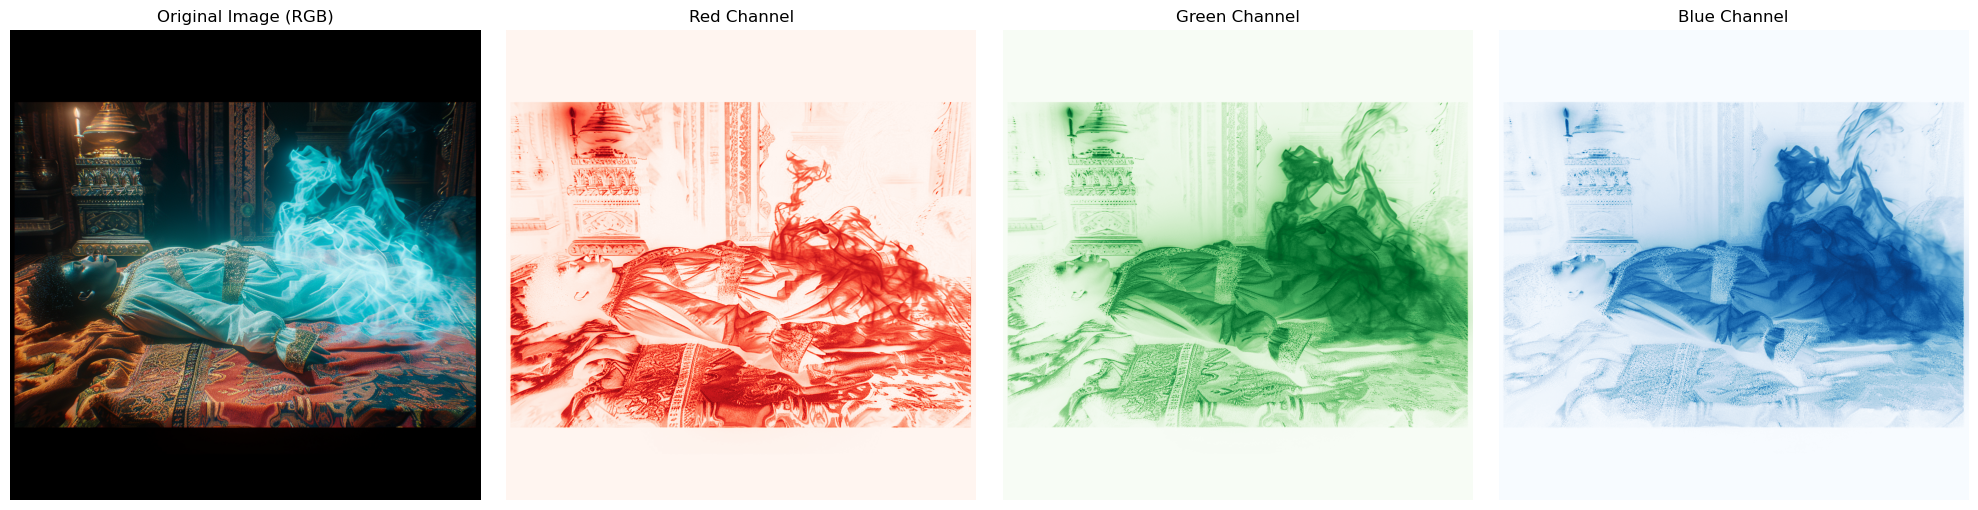

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import os
from tempfile import TemporaryDirectory
import ipywidgets as widgets
from IPython.display import clear_output, display

def convert_image_mode(image, mode):
    """Convert the image to the specified mode."""
    if mode in ['1', 'L', 'P', 'RGB', 'RGBA', 'CMYK', 'YCbCr', 'LAB', 'HSV', 'I', 'F']:
        return image.convert(mode)
    else:
        raise ValueError(f"Unsupported mode: {mode}")

def save_temp_image(image, temp_dir, mode):
    """Save the image in a format that supports the mode."""
    ext = 'png'  # Default to PNG, as it supports most modes
    if mode in ['CMYK', 'LAB', 'I', 'F']:
        ext = 'tiff'  # TIFF supports these modes better
    
    if mode in ['HSV', 'YCbCr']:
        # Convert to RGB for saving, then convert back to the original mode for visualization
        image = image.convert('RGB')
        temp_image_path = os.path.join(temp_dir, f'temp_image.{ext}')
        image.save(temp_image_path, format=ext.upper())
        return temp_image_path, mode
    
    temp_image_path = os.path.join(temp_dir, f'temp_image.{ext}')
    image.save(temp_image_path, format=ext.upper())
    return temp_image_path, mode

def visualize_image_mode(image):
    mode = image.mode
    img_array = np.array(image)

    if mode in ['1', 'L', 'I', 'F']:
        fig, axs = plt.subplots(1, 3, figsize=(20, 5))

        # Display original image
        axs[0].imshow(image, cmap='gray')
        axs[0].set_title(f'Original Image ({mode})')
        axs[0].axis('off')

        # Display histogram
        axs[1].hist(img_array.ravel(), bins=256, color='black')
        axs[1].set_title('Histogram')
        axs[1].set_xlim(0, 255 if mode == 'L' else None)
        axs[1].set_yscale('log')  # Use log scale for better visualization

        # Display gradient
        gradient = np.linspace(0, 1, 256)
        gradient = np.vstack((gradient, gradient))
        axs[2].imshow(gradient, aspect='auto', cmap='gray')
        axs[2].set_title('Gradient')
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()

    elif mode == 'P':
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        # Display original image
        axs[0].imshow(image)
        axs[0].set_title(f'Original Image ({mode})')
        axs[0].axis('off')

        # Display palette
        palette = image.getpalette()
        palette_image = Image.new('P', (16, 16))
        palette_image.putpalette(palette)
        palette_image = palette_image.convert('RGB')
        axs[1].imshow(palette_image)
        axs[1].set_title('Color Palette')
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()

    elif mode == 'RGB':
        r, g, b = image.split()
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))
        axs[0].imshow(image)
        axs[0].set_title('Original Image (RGB)')
        axs[1].imshow(r, cmap='Reds')
        axs[1].set_title('Red Channel')
        axs[2].imshow(g, cmap='Greens')
        axs[2].set_title('Green Channel')
        axs[3].imshow(b, cmap='Blues')
        axs[3].set_title('Blue Channel')
        for ax in axs:
            ax.axis('off')

    elif mode == 'RGBA':
        r, g, b, a = image.split()
        fig, axs = plt.subplots(1, 5, figsize=(25, 5))
        axs[0].imshow(image)
        axs[0].set_title('Original Image (RGBA)')
        axs[1].imshow(r, cmap='Reds')
        axs[1].set_title('Red Channel')
        axs[2].imshow(g, cmap='Greens')
        axs[2].set_title('Green Channel')
        axs[3].imshow(b, cmap='Blues')
        axs[3].set_title('Blue Channel')
        axs[4].imshow(a, cmap='gray')
        axs[4].set_title('Alpha Channel')
        for ax in axs:
            ax.axis('off')

    elif mode == 'CMYK':
        c, m, y, k = image.split()
        fig, axs = plt.subplots(1, 5, figsize=(25, 5))
        axs[0].imshow(image.convert('RGB'))
        axs[0].set_title('Original Image (CMYK)')
        axs[1].imshow(c, cmap='Blues')
        axs[1].set_title('Cyan Channel')
        axs[2].imshow(m, cmap='Reds')
        axs[2].set_title('Magenta Channel')
        axs[3].imshow(y, cmap='Oranges')
        axs[3].set_title('Yellow Channel')
        axs[4].imshow(k, cmap='gray')
        axs[4].set_title('Black Channel')
        for ax in axs:
            ax.axis('off')

    elif mode == 'YCbCr':
        y, cb, cr = image.split()
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))
        axs[0].imshow(image.convert('RGB'))
        axs[0].set_title('Original Image (YCbCr)')
        axs[1].imshow(y, cmap='gray')
        axs[1].set_title('Y Channel')
        axs[2].imshow(cb, cmap='Blues')
        axs[2].set_title('Cb Channel')
        axs[3].imshow(cr, cmap='Reds')
        axs[3].set_title('Cr Channel')
        for ax in axs:
            ax.axis('off')

    elif mode == 'LAB':
        l, a, b = image.split()
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))
        axs[0].imshow(image.convert('RGB'))
        axs[0].set_title('Original Image (LAB)')
        axs[1].imshow(l, cmap='gray')
        axs[1].set_title('L Channel')
        axs[2].imshow(a, cmap='gray')
        axs[2].set_title('A Channel')
        axs[3].imshow(b, cmap='gray')
        axs[3].set_title('B Channel')
        for ax in axs:
            ax.axis('off')

    elif mode == 'HSV':
        h, s, v = image.split()
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))
        axs[0].imshow(image.convert('RGB'))
        axs[0].set_title('Original Image (HSV)')
        axs[1].imshow(h, cmap='hsv')
        axs[1].set_title('Hue Channel')
        axs[2].imshow(s, cmap='gray')
        axs[2].set_title('Saturation Channel')
        axs[3].imshow(v, cmap='gray')
        axs[3].set_title('Value Channel')
        for ax in axs:
            ax.axis('off')

    else:
        fig, ax = plt.subplots()
        ax.text(0.5, 0.5, f'Visualization not available for {mode}', ha='center', va='center')
        ax.set_title('Color Mode Visualization')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

def run_visualization(image_info, test_mode):
    image_path = image_info['Path']
    actual_mode = image_info['Color Mode']
    
    with TemporaryDirectory() as temp_dir:
        image = Image.open(image_path)
        
        # Convert to test mode if different from actual mode
        if test_mode != actual_mode:
            converted_image = convert_image_mode(image, test_mode)
        else:
            converted_image = image
        
        # Save the image in a format that supports the mode
        temp_image_path, mode_to_visualize = save_temp_image(converted_image, temp_dir, test_mode)
        
        # Re-open the saved image to ensure compatibility
        converted_image = Image.open(temp_image_path)
        
        # Convert back to the test mode for visualization if needed
        if mode_to_visualize in ['HSV', 'YCbCr']:
            converted_image = convert_image_mode(converted_image, mode_to_visualize)
        
        visualize_image_mode(converted_image)

def on_color_mode_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        test_mode = change['new']
        clear_output(wait=True)  # Clear previous output
        display(color_mode_dropdown)  # Display the dropdown again
        run_visualization(image_info, test_mode)

# Create a dropdown widget for color mode selection
color_mode_dropdown = widgets.Dropdown(
    options=['1', 'L', 'P', 'RGB', 'RGBA', 'CMYK', 'YCbCr', 'LAB', 'HSV', 'I', 'F'],
    value=image_info["Color Mode"],
    description='Color Mode:',
    disabled=False,
)

# Attach the callback function to the dropdown
color_mode_dropdown.observe(on_color_mode_change)

# Display the dropdown
display(color_mode_dropdown)

# Main usage: Run with actual mode
run_visualization(image_info, image_info["Color Mode"])